In [1]:
!pip install matplotlib numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 12.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.9/930.9 KB 16.2 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import yaml
import datetime
import time

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
results_dir = Path("results")
nodes_file = results_dir / "nodes.yaml"

with nodes_file.open("r") as f:
    node_descriptors = yaml.load(f, Loader=yaml.FullLoader)
    
print(f"There are {len(node_descriptors)} nodes")

There are 15 nodes


In [4]:
node_descriptors[0]

{'cloud_instance_id': 'i-046310ea085e2ae4d',
 'cloud_lifecycle': 'normal',
 'configuration': {'instance': {'boot_disk_device': None,
   'boot_disk_iops': None,
   'boot_disk_size': 16,
   'boot_disk_snapshot': None,
   'boot_disk_type': None,
   'flavor': 't2.medium',
   'image_id': 'ami-0650ed74180c860f3',
   'instance_config_id': 'lammps-type-t2.medium',
   'login': 'login-ubuntu',
   'network_ids': [],
   'placement_group': None,
   'price': None,
   'provider': 'aws-config-us-east-1',
   'security_group': 'open-security-group',
   'timeout': None},
  'login': {'keypair_name': 'otavio_aws_2022_key',
   'keypair_private_file': 'key.pem',
   'keypair_public_file': 'key.pub',
   'login_config_id': 'login-ubuntu',
   'ssh_port': 22,
   'sudo': True,
   'sudo_user': 'root',
   'user': 'ubuntu'},
  'provider': {'access_keyfile': 'ec2_access_key.pub',
   'provider': 'aws',
   'provider_config_id': 'aws-config-us-east-1',
   'region': 'us-east-1',
   'secret_access_keyfile': 'ec2_access_key

In [5]:
def get_lammps_time(file: Path):
    with file.open("r") as f:
        last_line = f.readlines()[-1]
    
    wall_time = last_line.split("Total wall time: ")[1].strip()
    wall_time = time.strptime(wall_time, "%H:%M:%S")
    wall_time = datetime.timedelta(
        hours=wall_time.tm_hour,
        minutes=wall_time.tm_min,
        seconds=wall_time.tm_sec).total_seconds()
    return int(wall_time)

results = {
    result_file.parents[3].stem: get_lammps_time(result_file)
    for result_file in results_dir.rglob("*.stdout") 
}

results

{'59794c67db354b7f87340624c04e4dd0': 174,
 'bd768c6a66f445e7a11351a667e42b8a': 61,
 'dc8897c9bd31486dab80009367ef3385': 62,
 '1c674064c6324a90a13bf6b092afd80a': 78,
 'fcd71ec358ca49bcb6e43257a90b5b68': 119,
 '9b52a6a911cd401bb4c0e7985a12089a': 28,
 '419951bb461247c68b34115e596fb2da': 69,
 '98eaa8f47b444cf3afc295102886c2ac': 69,
 '7b30252402984d268d838fc9a8468fb7': 128,
 'b73ea280daca4f91a50b13844ba26b3c': 31,
 '5b9555a28ceb47e0b64aa6eafe108c9a': 80,
 '055a1b8ed33e4070b12f8544aea86cd2': 150,
 'af385a34e484447bbad51afad3beb5c8': 168,
 '4845d9798a284a6c9186c949c3cbb3d4': 203,
 '17505645616247a79c8f70ffd08778c1': 83}

In [6]:
wall_time_per_flavor = {}
for k, v in results.items():
    flavor = [node["configuration"]["instance"]["flavor"] for node in node_descriptors if node["node_id"] == k][0]
    wall_time_per_flavor[flavor] = v
    
wall_time_per_flavor

{'t2.medium': 174,
 'm5.2xlarge': 61,
 'r5.2xlarge': 62,
 'r4.2xlarge': 78,
 'r5.xlarge': 119,
 'c5.4xlarge': 28,
 'm5a.2xlarge': 69,
 'r5a.2xlarge': 69,
 'r5a.xlarge': 128,
 'r5.4xlarge': 31,
 'm4.2xlarge': 80,
 'r4.xlarge': 150,
 't2.large': 168,
 'c5.large': 203,
 'x1e.2xlarge': 83}

In [7]:
instance_price_per_second = {
    't2.medium':    0.0464/3600,
    'r4.2xlarge':   0.5320/3600,
    'r5.xlarge':    0.2520/3600,
    'm4.2xlarge':   0.4000/3600,
    'm5.2xlarge':   0.3840/3600,
    'r5a.xlarge':   0.2260/3600,
    'c5.4xlarge':   0.6800/3600,
    'r5a.2xlarge':  0.4520/3600,
    'r5.4xlarge':   1.0080/3600,
    'r5.2xlarge':   0.5040/3600,
    't2.large':     0.0928/3600,
    'm5a.2xlarge':  0.3440/3600,
    'c5.large':     0.0850/3600,
    'r4.xlarge':    0.2660/3600,
    'x1e.2xlarge':  1.6680/3600
}

instance_price_per_second

{'t2.medium': 1.2888888888888887e-05,
 'r4.2xlarge': 0.0001477777777777778,
 'r5.xlarge': 7e-05,
 'm4.2xlarge': 0.00011111111111111112,
 'm5.2xlarge': 0.00010666666666666667,
 'r5a.xlarge': 6.277777777777778e-05,
 'c5.4xlarge': 0.0001888888888888889,
 'r5a.2xlarge': 0.00012555555555555557,
 'r5.4xlarge': 0.00028,
 'r5.2xlarge': 0.00014,
 't2.large': 2.5777777777777775e-05,
 'm5a.2xlarge': 9.555555555555554e-05,
 'c5.large': 2.3611111111111114e-05,
 'r4.xlarge': 7.38888888888889e-05,
 'x1e.2xlarge': 0.00046333333333333334}

In [8]:
perf_per_cost = {
    instance: wall_time_per_flavor[instance]/price
    for instance, price in instance_price_per_second.items()
}

perf_per_cost

{'t2.medium': 13500000.000000002,
 'r4.2xlarge': 527819.5488721804,
 'r5.xlarge': 1700000.0000000002,
 'm4.2xlarge': 720000.0,
 'm5.2xlarge': 571875.0,
 'r5a.xlarge': 2038938.053097345,
 'c5.4xlarge': 148235.29411764705,
 'r5a.2xlarge': 549557.5221238937,
 'r5.4xlarge': 110714.28571428572,
 'r5.2xlarge': 442857.1428571429,
 't2.large': 6517241.379310345,
 'm5a.2xlarge': 722093.0232558141,
 'c5.large': 8597647.058823528,
 'r4.xlarge': 2030075.1879699246,
 'x1e.2xlarge': 179136.690647482}

In [9]:
sorted(perf_per_cost.items(), key=lambda x: x[1]) 

[('r5.4xlarge', 110714.28571428572),
 ('c5.4xlarge', 148235.29411764705),
 ('x1e.2xlarge', 179136.690647482),
 ('r5.2xlarge', 442857.1428571429),
 ('r4.2xlarge', 527819.5488721804),
 ('r5a.2xlarge', 549557.5221238937),
 ('m5.2xlarge', 571875.0),
 ('m4.2xlarge', 720000.0),
 ('m5a.2xlarge', 722093.0232558141),
 ('r5.xlarge', 1700000.0000000002),
 ('r4.xlarge', 2030075.1879699246),
 ('r5a.xlarge', 2038938.053097345),
 ('t2.large', 6517241.379310345),
 ('c5.large', 8597647.058823528),
 ('t2.medium', 13500000.000000002)]

In [10]:
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

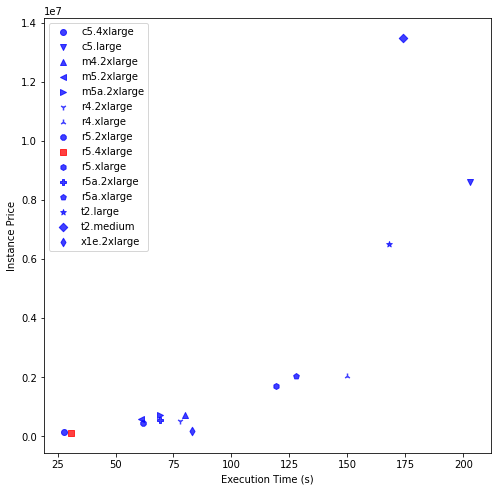

In [11]:
instances = sorted(perf_per_cost.keys())
costs = np.array([[perf_per_cost[i]] for i in instances])
paretto_colors = ["red"  if i==True else "blue" for i in is_pareto_efficient(costs)]
xs = [wall_time_per_flavor[i] for i in instances]
ys = [perf_per_cost[i] for i in instances]

markers = ["o", "v", "^", "<", ">", "1", "2", "8", "s", "h", "P", "p", "*", "D", "d"]*2
fig, ax = plt.subplots(figsize=(8, 8))

for label, x, y, marker, color in zip(instances, xs, ys, markers, paretto_colors):
    ax.scatter(x, y, label=label, marker=marker, c=color, alpha=0.75)
    
ax.set_xlabel("Execution Time (s)")
ax.set_ylabel("Instance Price")
ax.legend()
plt.show()